In [2]:
import time
import tensorflow as tf
def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

for i in range(2):
    # исполнение CPU
    print(" CPU работает:")
    with tf.device("CPU:0"):
      x = tf.random.uniform([1000, 1000])
      assert x.device.endswith("CPU:0")
      time_matmul(x)

    # исполнение на GPU #0 , если доступен
    if tf.config.experimental.list_physical_devices("GPU"):
      print(" GPU работает:")
      with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

 CPU работает:
100 циклов: 351.32ms
 GPU работает:
100 циклов: 6.00ms
 CPU работает:
100 циклов: 342.31ms
 GPU работает:
100 циклов: 6.00ms


# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
patch_train = r'D:\train\imdb/train.tsv'
patch_test = r'D:\train\imdb/test.tsv'

In [4]:
import pandas as pd

train_df = pd.read_csv(patch_train, delimiter="\t",encoding='utf-8')
test_df = pd.read_csv(patch_test, delimiter="\t",encoding='utf-8')

print(f'Train size = {len(train_df)}')
print(f'Test size = {len(test_df)}')

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [ ]:
# Проыверим сбалансированая ли выборка

In [5]:
train_df.is_positive.value_counts()

0    12500
1    12500
Name: is_positive, dtype: int64

точно 50/50, acuracy будет работать предельно четко

In [6]:
train_df.loc[3,'review']

'Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we\'ll start from the top...<br /><br />THE STORY: Don\'t believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It\'s a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it\'s hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you\'d uh...if you\'d like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take 

In [8]:

positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text.lower() for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text.lower() for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 67.18%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

In [14]:
import re
from nltk.corpus import stopwords
def removeSpecialChars(review):
     return re.sub('[^a-zA-Z]', ' ', review)
def doCleaningFixed(review):
    review = removeSpecialChars(review) 
    review = review.lower()  
    review = review.split() #Tokenization
    review = [word for word in review if not word in set(stopwords.words('english'))]
#     review = " ".join(review)    
    return review

In [63]:
train_df['clean'] = train_df.review.apply(doCleaningFixed)

In [61]:
test_df['clean'] = test_df.review.apply(doCleaningFixed)

In [16]:
from collections import Counter

In [17]:
p_w = Counter()
n_w = Counter()
train_df.clean.loc[train_df.is_positive == 1].apply(lambda x:p_w.update(x) )
train_df.clean.loc[train_df.is_positive == 0].apply(lambda x:n_w.update(x) )
print('ok')

ok


In [18]:
work_p_w = p_w.copy()

for w,s in p_w.items():
    if s>10000 or s<50:
        work_p_w[w] = 0
    try:
        s_n =n_w[w]
        if s<s_n:
            work_p_w[w] = 0
        else:
            work_p_w[w] = s-s_n
    except:
        continue

In [19]:
work_p_w.most_common()[:20]

[('great', 3777),
 ('best', 2224),
 ('well', 2154),
 ('love', 2150),
 ('also', 1943),
 ('life', 1774),
 ('film', 1720),
 ('story', 1570),
 ('excellent', 1295),
 ('wonderful', 1086),
 ('still', 1058),
 ('young', 1026),
 ('world', 1025),
 ('years', 998),
 ('beautiful', 986),
 ('performance', 962),
 ('man', 948),
 ('always', 938),
 ('series', 889),
 ('perfect', 886)]

In [20]:
work_n_w = n_w.copy()

for w,s in n_w.items():
    if s>10000 or s<50:
        work_n_w[w] = 0
    try:
        s_p =p_w[w]
        if s<s_p:
            work_n_w[w] = 0
        else:
            work_n_w[w] = s-s_p
    except:
        continue

In [21]:
negative_words = [i[0] for i in work_n_w.most_common() if i[1]>100]
positive_words = [i[0] for i in work_p_w.most_common() if i[1]>100]

In [22]:
len(negative_words),len(positive_words)


(445, 533)

In [23]:
negative_words[:25]

['movie',
 'bad',
 'br',
 'even',
 'worst',
 'like',
 'plot',
 'nothing',
 'would',
 'acting',
 'could',
 'make',
 'awful',
 'minutes',
 'waste',
 'thing',
 'stupid',
 'boring',
 'terrible',
 'script',
 'poor',
 'worse',
 'better',
 'money',
 'least']

In [24]:
positive_words[:25]

['great',
 'best',
 'well',
 'love',
 'also',
 'life',
 'film',
 'story',
 'excellent',
 'wonderful',
 'still',
 'young',
 'world',
 'years',
 'beautiful',
 'performance',
 'man',
 'always',
 'series',
 'perfect',
 'family',
 'many',
 'amazing',
 'loved',
 'role']

Посчитаем результат

Test accuracy = 78.85%


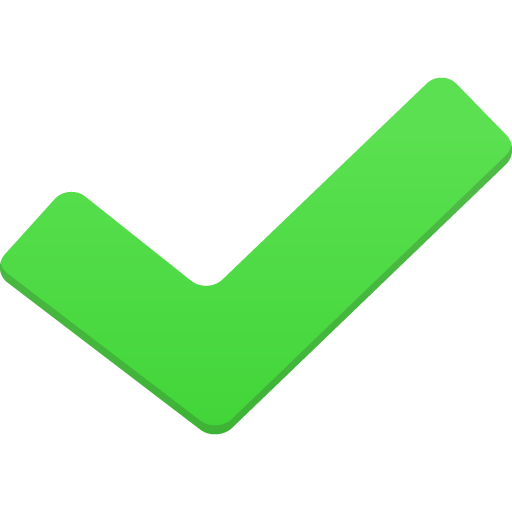

Wall time: 57.4 s


In [25]:
%%time
positives_count = test_df.review.apply(lambda text: sum(word in text.lower() for word in positive_words[:]))
negatives_count = test_df.review.apply(lambda text: sum(word in text.lower() for word in negative_words[:]))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('success.png', width=300))

Как видно результат стал гораздо лучше

In [65]:
# Преобразуем поле clean и посмотрим результаты на поле clean
train_df.clean = train_df.clean.apply(lambda x: ', '.join(x))
test_df.clean = test_df.clean.apply(lambda x: ', '.join(x))

Test accuracy = 78.84%


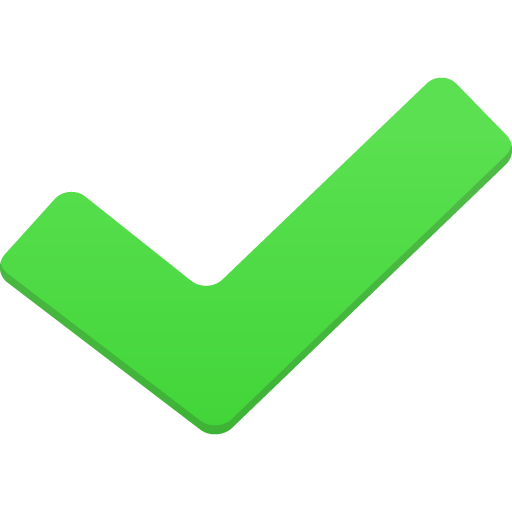

Wall time: 30.3 s


In [68]:
%%time
positives_count = test_df.clean.apply(lambda text: sum(word in text.lower() for word in positive_words[:]))
negatives_count = test_df.clean.apply(lambda text: sum(word in text.lower() for word in negative_words[:]))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('success.png', width=300))

Как видно результат такой же

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [69]:
train_df

,is_positive,review,clean
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirls, despite, fistful, tony, wins, incr..."
1,0,This show comes up with interesting locations ...,"show, comes, interesting, locations, fast, tra..."
2,1,I simply love this movie. I also love the Ramo...,"simply, love, movie, also, love, ramones, sort..."
3,0,Spoilers ahead if you want to call them that.....,"spoilers, ahead, want, call, would, almost, re..."
4,1,My all-time favorite movie! I have seen many m...,"time, favorite, movie, seen, many, movies, one..."
...,...,...,...
24995,1,"I am a big fan of the movie, but not for the u...","big, fan, movie, usual, reasons, think, travol..."
24996,0,I'm not going to bother with a plot synopsis s...,"going, bother, plot, synopsis, since, know, mo..."
24997,0,This movie . . . I don't know. Why they would ...,"movie, know, would, take, indellible, characte..."
24998,1,Saw this film on DVD yesterday and was gob-sma...,"saw, film, dvd, yesterday, gob, smacked, flabb..."


In [70]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(50*'=')
print(pattern.sub(' ', train_df['review'].iloc[3]))

Spoilers ahead if you want to call them that...  I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...  THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".  THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.  THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one step further and say that they actually 

Применим ее:

In [71]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.sub(' ', text))
test_df['review'] = test_df['review'].apply(lambda text: pattern.sub(' ', text))

In [72]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


In [73]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'])

CountVectorizer()

Попробуем кого-нибудь таки сконвертировать

In [75]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

Посмтроим линеную модель

In [517]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
vectorizer_c= CountVectorizer()
classifier = LogisticRegression(n_jobs=15,max_iter=2000)
classifier_c = LogisticRegression(n_jobs=15,max_iter=2000)
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model_clean = Pipeline([
    ('vectorizer', vectorizer_c),
    ('classifier', classifier_c)
])
model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [518]:
model.fit(train_df['review'], train_df['is_positive'])
model_clean.fit(train_df['clean'], train_df['is_positive'])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression(max_iter=2000, n_jobs=15))])

In [519]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df,col):
    preds = model.predict(test_df[col])
    print(f'Test accuracy -  {col} = {accuracy_score(test_df["is_positive"], preds)*100} %')
    
eval_model(model, test_df,col='review')
eval_model(model_clean, test_df,col='clean')

Test accuracy -  review = 86.664 %
Test accuracy -  clean = 86.316 %


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [520]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.585,refreshing
+1.411,wonderfully
+1.354,erotic
+1.296,funniest
+1.288,perfect
+1.282,excellent
+1.280,carrey
+1.260,superb
+1.250,surprisingly
+1.250,appreciated


Посмотрим на конкретные примеры его работы:

In [89]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [90]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [91]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df,col='review')

Test accuracy review = 0.88284


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [93]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df = 15000,  min_df=80)
classifier = LogisticRegression(n_jobs=16,max_iter=2000)

vectorizer_c = TfidfVectorizer(ngram_range=(1, 2),max_df = 15000,  min_df=80)
classifier_c = LogisticRegression(n_jobs=16,max_iter=2000)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model_c = Pipeline([
    ('vectorizer', vectorizer_c),
    ('classifier', classifier_c)
])

model.fit(train_df['review'], train_df['is_positive'])
model_c.fit(train_df['clean'], train_df['is_positive'])

eval_model(model, test_df,col='review')
eval_model(model_c, test_df,col='clean')

Test accuracy review = 0.89528
Test accuracy clean = 0.8852


не очищенный текст работает лучще

In [521]:
eli5.show_weights(classifier_c, vec=vectorizer_c, top=40)

Weight?,Feature
+1.566,refreshing
+1.497,wonderfully
+1.364,funniest
+1.354,superb
+1.316,carrey
+1.259,excellent
+1.257,perfect
+1.252,flawless
+1.234,erotic
+1.229,surprisingly


In [522]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.585,refreshing
+1.411,wonderfully
+1.354,erotic
+1.296,funniest
+1.288,perfect
+1.282,excellent
+1.280,carrey
+1.260,superb
+1.250,surprisingly
+1.250,appreciated


In [99]:
# Попробуем удалить некторые слова
my_stop_w = ['today','bit','both','definitely','still','minutes','instead','avoid','save','even','at all','script','also',
            'world','noir','idea','would','basically','redeeming','money','wonder','reason','unless','supposed']

In [102]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df = 15000,  min_df=80,stop_words= my_stop_w )
classifier = LogisticRegression(n_jobs=16,max_iter=2000)

vectorizer_c = TfidfVectorizer(ngram_range=(1, 2),max_df = 15000,  min_df=80,stop_words= my_stop_w)
classifier_c = LogisticRegression(n_jobs=16,max_iter=2000)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model_c = Pipeline([
    ('vectorizer', vectorizer_c),
    ('classifier', classifier_c)
])

model.fit(train_df['review'], train_df['is_positive'])
model_c.fit(train_df['clean'], train_df['is_positive'])

eval_model(model, test_df,col='review')
eval_model(model_c, test_df,col='clean')

Test accuracy -  review = 89.2 %
Test accuracy -  clean = 88.144 %


Как видно стало хуже

Потестируем на N граммах слов

In [194]:
%%time
for n_g in [(1,1),(1,2),(1,3),(1,4),(1,5),(2,2),(2,3),(2,4),(2,5),(3,3),(3,4)]:
    vectorizer = TfidfVectorizer(ngram_range=n_g, max_df = 15000,  min_df=80)
    classifier = LogisticRegression(n_jobs=16,max_iter=2000)
    model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
                    ])
    model.fit(train_df['review'], train_df['is_positive'])
    print(f'n-грамм слов {n_g}')
    eval_model(model, test_df)
    
    print('='*100)
    
    

n-грамм слов (1, 1)
Test accuracy = 88.58%
n-грамм слов (1, 2)
Test accuracy = 89.53%
n-грамм слов (1, 3)
Test accuracy = 89.52%
n-грамм слов (1, 4)
Test accuracy = 89.55%
n-грамм слов (1, 5)
Test accuracy = 89.54%
n-грамм слов (2, 2)
Test accuracy = 85.86%
n-грамм слов (2, 3)
Test accuracy = 85.82%
n-грамм слов (2, 4)
Test accuracy = 85.77%
n-грамм слов (2, 5)
Test accuracy = 85.79%
n-грамм слов (3, 3)
Test accuracy = 75.42%
n-грамм слов (3, 4)
Test accuracy = 75.25%
Wall time: 4min 58s


Лучший результаты дают n-грамм слов (1, 2) ,(1,3), (1,4), (1,5)

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [206]:
%%time
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_df = 22000,  min_df=60, analyzer='char_wb')
classifier = LogisticRegression(n_jobs=16,max_iter=2000)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.87%
Wall time: 2min 8s


In [209]:
%%time
for n_g in [(2,4),(2,5),(2,6),(2,7),(2,8),(2,9),(2,10),(3,4),(3,5),(3,6),(3,7),(3,8),(3,9),(3,10),(4,5),(4,6),(4,7),(4,8),(4,9),(4,10)]:
    vectorizer = TfidfVectorizer(ngram_range=n_g, max_df = 22000,  min_df=70,analyzer='char_wb')
    classifier = LogisticRegression(n_jobs=16,max_iter=2000)
    model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
                    ])
    model.fit(train_df['review'], train_df['is_positive'])
    print(f'n-грамм ноабора символов {n_g}')
    eval_model(model, test_df)
    
    print('='*100)

n-грамм ноабора символов (2, 4)
Test accuracy = 88.12%
n-грамм ноабора символов (2, 5)
Test accuracy = 88.74%
n-грамм ноабора символов (2, 6)
Test accuracy = 88.88%
n-грамм ноабора символов (2, 7)
Test accuracy = 88.94%
n-грамм ноабора символов (2, 8)
Test accuracy = 88.90%
n-грамм ноабора символов (2, 9)
Test accuracy = 88.92%
n-грамм ноабора символов (2, 10)
Test accuracy = 88.95%
n-грамм ноабора символов (3, 4)
Test accuracy = 88.10%
n-грамм ноабора символов (3, 5)
Test accuracy = 88.67%
n-грамм ноабора символов (3, 6)
Test accuracy = 88.84%
n-грамм ноабора символов (3, 7)
Test accuracy = 88.96%
n-грамм ноабора символов (3, 8)
Test accuracy = 88.99%
n-грамм ноабора символов (3, 9)
Test accuracy = 89.01%
n-грамм ноабора символов (3, 10)
Test accuracy = 89.00%
n-грамм ноабора символов (4, 5)
Test accuracy = 88.81%
n-грамм ноабора символов (4, 6)
Test accuracy = 88.97%
n-грамм ноабора символов (4, 7)
Test accuracy = 88.96%
n-грамм ноабора символов (4, 8)
Test accuracy = 88.90%
n-грамм 

Лучшие результаты показали (3,10) c 89 %. То есть разбиение по символам не увеличело результат

In [211]:
vectorizer = TfidfVectorizer(ngram_range=(3,10), max_df = 22000,  min_df=70,analyzer='char_wb')
classifier = LogisticRegression(n_jobs=16,max_iter=2000)
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
                    ])
model.fit(train_df['review'], train_df['is_positive'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char_wb', max_df=22000, min_df=70,
                                 ngram_range=(3, 10))),
                ('classifier', LogisticRegression(max_iter=2000, n_jobs=16))])

In [212]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [213]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [28]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_trf', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:])]

In [29]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_,sep='\n')

Dreamgirls
Dreamgirls
B
WORK_OF_ART
,
,
O

despite
despite
O

its
its
O

fistful
fistful
O

of
of
O

Tony
Tony
B
WORK_OF_ART
wins
win
O

in
in
O

an
an
B
DATE
incredibly
incredibly
I
DATE
weak
weak
I
DATE
year
year
I
DATE
on
on
O

Broadway
Broadway
B
FAC
,
,
O

has
have
O

never
never
O

been
be
O

what
what
O

one
one
O

would
would
O

call
call
O

a
a
O

jewel
jewel
O

in
in
O

the
the
O

crown
crown
O

of
of
O

stage
stage
O

musicals
musical
O

.
.
O

However
however
O

,
,
O

that
that
O

is
be
O

not
not
O

to
to
O

say
say
O

that
that
O

in
in
O

the
the
O

right
right
O

cinematic
cinematic
O

hands
hand
O

it
it
O

could
could
O

not
not
O

be
be
O

fleshed
flesh
O

out
out
O

and
and
O

polished
polish
O

into
into
O

something
something
O

worthwhile
worthwhile
O

on
on
O

-
-
O

screen
screen
O

.
.
O

Unfortunately
unfortunately
O

,
,
O

what
what
O

transfers
transfer
O

to
to
O

the
the
O

screen
screen
O

is
be
O

basically
basically
O

a
a
O

slavishly
slavishly
O

f

In [30]:
docs_t = [doc for doc in nlp.pipe(test_df.review.values[:])]

In [31]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_,sep='\n')

Dreamgirls
Dreamgirls
B
WORK_OF_ART
,
,
O

despite
despite
O

its
its
O

fistful
fistful
O

of
of
O

Tony
Tony
B
WORK_OF_ART
wins
win
O

in
in
O

an
an
B
DATE
incredibly
incredibly
I
DATE
weak
weak
I
DATE
year
year
I
DATE
on
on
O

Broadway
Broadway
B
FAC
,
,
O

has
have
O

never
never
O

been
be
O

what
what
O

one
one
O

would
would
O

call
call
O

a
a
O

jewel
jewel
O

in
in
O

the
the
O

crown
crown
O

of
of
O

stage
stage
O

musicals
musical
O

.
.
O

However
however
O

,
,
O

that
that
O

is
be
O

not
not
O

to
to
O

say
say
O

that
that
O

in
in
O

the
the
O

right
right
O

cinematic
cinematic
O

hands
hand
O

it
it
O

could
could
O

not
not
O

be
be
O

fleshed
flesh
O

out
out
O

and
and
O

polished
polish
O

into
into
O

something
something
O

worthwhile
worthwhile
O

on
on
O

-
-
O

screen
screen
O

.
.
O

Unfortunately
unfortunately
O

,
,
O

what
what
O

transfers
transfer
O

to
to
O

the
the
O

screen
screen
O

is
be
O

basically
basically
O

a
a
O

slavishly
slavishly
O

f

O

no
no
O

father
father
O

"
"
O

and
and
O

then
then
O

refuse
refuse
O

to
to
O

look
look
O

for
for
O

gainful
gainful
O

employment
employment
O

to
to
O

support
support
O

them
they
O

since
since
O

singing
singing
O

is
be
O

all
all
O

she
she
O

knows
know
O

.
.
O

In
in
O

the
the
O

hands
hand
O

of
of
O

a
a
O

skillful
skillful
O

actress
actress
O

,
,
O

the
the
O

gaps
gap
O

could
could
O

perhaps
perhaps
O

have
have
O

been
be
O

remedied
remedie
O

with
with
O

technique
technique
O

and
and
O

charisma
charisma
O

.
.
O

Unfortunately
unfortunately
O

,
,
O

Hudson
Hudson
B
PERSON
is
be
O

not
not
O

that
that
O

actress
actress
O

.
.
O

She
she
O

sings
sing
O

well
well
O

,
,
O

but
but
O

the
the
O

dialog
dialog
O

-
-
O

driven
drive
O

moments
moment
O

do
do
O

not
not
O

come
come
O

naturally
naturally
O

to
to
O

her
she
O

nor
nor
O

do
do
O

high
high
O

emotional
emotional
O

moments
moment
O

.
.
O

Effie
Effie
B
PERSON
's
's
O

signature
sign

In [103]:
pat_train = r'D:\train\imdb\lema_train/'
pat_test = r'D:\train\imdb\lema_test/'

Запишем данные в файлы. Памяти не зватает сделать это по другому. 

In [62]:
for ind,doc in enumerate(docs):
    for token in doc:
        with open (pat_train+str(ind)+'.txt','w',encoding='utf-8') as f:
            f.write(str([i.lemma_ for i in doc] ) +'\n')            
            f.write(str([i.ent_iob_ for i in doc])+'\n')
            f.write(str([i.ent_type_ for i in doc])+'\n')

In [70]:
for ind,doc in enumerate(docs_t):
    for token in doc:
        with open (pat_test+str(ind)+'.txt','w',encoding='utf-8') as f:
            f.write(str([i.lemma_ for i in doc] ) +'\n')            
            f.write(str([i.ent_iob_ for i in doc])+'\n')
            f.write(str([i.ent_type_ for i in doc])+'\n')

После перезагрузки перезапишем данные

In [142]:
arr_lemm=[]
arr_ent_iob= []
arr_ent_type=[]
for i in range(25000):
    with open (pat_train+str(i)+'.txt',encoding='utf-8') as f:
        lemm = eval(f.readline()[:-1])
        ent_iob = eval(f.readline()[:-1])
        ent_type=eval(f.readline()[:-1])
    arr_lemm.append(lemm)
    arr_ent_iob.append(ent_iob)
    arr_ent_type.append(ent_type)
train_df['lemm'] =arr_lemm 
train_df['ent_iob'] =arr_ent_iob   
train_df['ent_type'] =arr_ent_type   

In [143]:
train_df


,is_positive,review,clean,lemm,ent_iob,ent_type
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirls, despite, fistful, tony, wins, incr...","[Dreamgirls, ,, despite, its, fistful, of, Ton...","[B, O, O, O, O, O, B, O, O, B, I, I, I, O, B, ...","[WORK_OF_ART, , , , , , WORK_OF_ART, , , DATE,..."
1,0,This show comes up with interesting locations ...,"show, comes, interesting, locations, fast, tra...","[this, show, come, up, with, interesting, loca...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
2,1,I simply love this movie. I also love the Ramo...,"simply, love, movie, also, love, ramones, sort...","[I, simply, love, this, movie, ., I, also, lov...","[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ...","[, , , , , , , , , , PERSON, , , , , , , , , ,..."
3,0,Spoilers ahead if you want to call them that.....,"spoilers, ahead, want, call, would, almost, re...","[spoiler, ahead, if, you, want, to, call, they...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
4,1,My all-time favorite movie! I have seen many m...,"time, favorite, movie, seen, many, movies, one...","[my, all, -, time, favorite, movie, !, I, have...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
...,...,...,...,...,...,...
24995,1,"I am a big fan of the movie, but not for the u...","big, fan, movie, usual, reasons, think, travol...","[I, be, a, big, fan, of, the, movie, ,, but, n...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , PERSON, ,..."
24996,0,I'm not going to bother with a plot synopsis s...,"going, bother, plot, synopsis, since, know, mo...","[I, be, not, go, to, bother, with, a, plot, sy...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
24997,0,This movie . . . I don't know. Why they would ...,"movie, know, would, take, indellible, characte...","[this, movie, ., ., ., I, do, n't, know, ., wh...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , PERSON,..."
24998,1,Saw this film on DVD yesterday and was gob-sma...,"saw, film, dvd, yesterday, gob, smacked, flabb...","[see, this, film, on, DVD, yesterday, and, be,...","[O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, ...","[, , , , , DATE, , , , , , , , , , , , , WORK_..."


In [144]:
arr_lemm=[]
arr_ent_iob= []
arr_ent_type=[]
for i in range(25000):
    with open (pat_test+str(i)+'.txt',encoding='utf-8') as f:
        lemm = eval(f.readline()[:-1])
        ent_iob = eval(f.readline()[:-1])
        ent_type=eval(f.readline()[:-1])
    arr_lemm.append(lemm)
    arr_ent_iob.append(ent_iob)
    arr_ent_type.append(ent_type)
test_df['lemm'] =arr_lemm 
test_df['ent_iob'] =arr_ent_iob   
test_df['ent_type'] =arr_ent_type   

In [145]:
test_df

,is_positive,review,clean,lemm,ent_iob,ent_type
0,0,A formulaic story with all the tired cliches. ...,"formulaic, story, tired, cliches, shocked, hor...","[a, formulaic, story, with, all, the, tired, c...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
1,1,This is both an entertaining and a touching ve...,"entertaining, touching, version, classic, tale...","[this, be, both, an, entertaining, and, a, tou...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , W..."
2,0,Corey Haim is never going to be known as one o...,"corey, haim, never, going, known, one, great, ...","[Corey, Haim, be, never, go, to, be, know, as,...","[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[PERSON, PERSON, , , , , , , , , , , , , , , ,..."
3,1,If you believe that any given war movie can ma...,"believe, given, war, movie, make, really, feel...","[if, you, believe, that, any, give, war, movie...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
4,1,Carla Gugino literally melts the screen in thi...,"carla, gugino, literally, melts, screen, crime...","[Carla, Gugino, literally, melt, the, screen, ...","[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[PERSON, PERSON, , , , , , , , , , , , , , , ,..."
...,...,...,...,...,...,...
24995,0,This entry doesn't contain a spoiler. It doesn...,"entry, contain, spoiler, movie, predictable, s...","[this, entry, do, n't, contain, a, spoiler, .,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
24996,1,"This is a multi-faceted, insightful and bold s...","multi, faceted, insightful, bold, story, peopl...","[this, be, a, multi, -, faceted, ,, insightful...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
24997,1,this movie had me stuck in this endless loop o...,"movie, stuck, endless, loop, thinking, days, a...","[this, movie, have, I, stick, in, this, endles...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, ...","[, , , , , , , , , , , , , , DATE, , , , , , ,..."
24998,1,this moving was intriguing and absorbing; howe...,"moving, intriguing, absorbing, however, story,...","[this, moving, be, intriguing, and, absorbing,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,..."


Сделаем столбец где леммы, не в словаре а в строке

In [148]:
train_df['lemma_text'] = train_df.lemm.apply(lambda x: ', '.join(x))
test_df['lemma_text'] = test_df.lemm.apply(lambda x: ', '.join(x))

In [162]:
train_df

,is_positive,review,clean,lemm,ent_iob,ent_type,lemma_text
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirls, despite, fistful, tony, wins, incr...","[Dreamgirls, ,, despite, its, fistful, of, Ton...","[B, O, O, O, O, O, B, O, O, B, I, I, I, O, B, ...","[WORK_OF_ART, , , , , , WORK_OF_ART, , , DATE,...","Dreamgirls, ,, despite, its, fistful, of, Tony..."
1,0,This show comes up with interesting locations ...,"show, comes, interesting, locations, fast, tra...","[this, show, come, up, with, interesting, loca...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","this, show, come, up, with, interesting, locat..."
2,1,I simply love this movie. I also love the Ramo...,"simply, love, movie, also, love, ramones, sort...","[I, simply, love, this, movie, ., I, also, lov...","[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ...","[, , , , , , , , , , PERSON, , , , , , , , , ,...","I, simply, love, this, movie, ., I, also, love..."
3,0,Spoilers ahead if you want to call them that.....,"spoilers, ahead, want, call, would, almost, re...","[spoiler, ahead, if, you, want, to, call, they...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","spoiler, ahead, if, you, want, to, call, they,..."
4,1,My all-time favorite movie! I have seen many m...,"time, favorite, movie, seen, many, movies, one...","[my, all, -, time, favorite, movie, !, I, have...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","my, all, -, time, favorite, movie, !, I, have,..."
...,...,...,...,...,...,...,...
24995,1,"I am a big fan of the movie, but not for the u...","big, fan, movie, usual, reasons, think, travol...","[I, be, a, big, fan, of, the, movie, ,, but, n...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , PERSON, ,...","I, be, a, big, fan, of, the, movie, ,, but, no..."
24996,0,I'm not going to bother with a plot synopsis s...,"going, bother, plot, synopsis, since, know, mo...","[I, be, not, go, to, bother, with, a, plot, sy...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","I, be, not, go, to, bother, with, a, plot, syn..."
24997,0,This movie . . . I don't know. Why they would ...,"movie, know, would, take, indellible, characte...","[this, movie, ., ., ., I, do, n't, know, ., wh...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , PERSON,...","this, movie, ., ., ., I, do, n't, know, ., why..."
24998,1,Saw this film on DVD yesterday and was gob-sma...,"saw, film, dvd, yesterday, gob, smacked, flabb...","[see, this, film, on, DVD, yesterday, and, be,...","[O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, ...","[, , , , , DATE, , , , , , , , , , , , , WORK_...","see, this, film, on, DVD, yesterday, and, be, ..."


Потестируем на леммах

In [161]:
for n_g in [(1,1),(1,2),(1,3),(1,4),(1,5),(1,6),(1,7)]:
    vectorizer = TfidfVectorizer(ngram_range=n_g, max_df = 14000,  min_df=40,lowercase=False)
    classifier = LogisticRegression(n_jobs=16,max_iter=2000)
    model = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
                        ])
    model.fit(train_df['lemma_text'],train_df['is_positive'])
    print(f'n-грамм слов {n_g}')
    eval_model(model, test_df,'lemma_text')

    print('='*100)

n-грамм слов (1, 1)
Test accuracy -  lemma_text = 88.13600000000001 %
n-грамм слов (1, 2)
Test accuracy -  lemma_text = 89.62 %
n-грамм слов (1, 3)
Test accuracy -  lemma_text = 89.63600000000001 %
n-грамм слов (1, 4)
Test accuracy -  lemma_text = 89.712 %
n-грамм слов (1, 5)
Test accuracy -  lemma_text = 89.708 %
n-грамм слов (1, 6)
Test accuracy -  lemma_text = 89.688 %
n-грамм слов (1, 7)
Test accuracy -  lemma_text = 89.688 %


Как видно результат немного улучшился (1,4) - 89,712 Это пока лучший результат

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [ ]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [169]:
def change_ner(x):
    my_data = x.lemm.copy()
    for  ind,ner  in enumerate(x.ent_type):
        if ner=="":
            continue
        my_data[ind]=ner 
    return my_data    
        

In [170]:
train_df['change_ner'] = train_df.apply(change_ner,axis=1)

In [184]:
for i,j in enumerate(train_df.change_ner.loc[1]):
    print(i,j)


0 this
1 show
2 come
3 up
4 with
5 interesting
6 location
7 as
8 fast
9 as
10 the
11 travel
12 channel
13 .
14 it
15 be
16 bill
17 as
18 reality
19 but
20 in
21 actuality
22 it
23 be
24 pure
25 prime
26 time
27 soap
28 opera
29 .
30 it
31 's
32 try
33 to
34 use
35 exotic
36 locale
37 as
38 a
39 facade
40 to
41 bring
42 people
43 into
44 a
45 phony
46 contest
47 &
48 then
49 proceed
50 to
51 hook
52 viewer
53 on
54 the
55 contestant
56 soap
57 opera
58 style
59 .
60  
61 it
62 also
63 borrow
64 from
65 an
66 early
67 ORG
68 game
69 show
70 pioneer-
71 ORG
72 ORG
73 ORG
74 by
75 invent
76 situation
77 for
78 its
79 contestant
80 to
81 try
82 &
83 overcome
84 .
85 then
86 it
87 reward
88 the
89 winner
90 money
91 .
92 if
93 they
94 can
95 spice
96 it
97 up
98 with
99 a
100 little
101 interaction
102 between
103 the
104 character
105 ,
106 even
107 well
108 .
109 while
110 the
111 game
112 format
113 be
114 in
115 slow
116 motion
117 versus
118 WORK_OF_ART
119 WORK_OF_ART
120 WORK_OF_ART
1

In [183]:
for i,j in enumerate(train_df.ent_type.loc[1]):
    print(i,j)

0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 ORG
68 
69 
70 
71 ORG
72 ORG
73 ORG
74 
75 
76 
77 
78 
79 
80 
81 
82 
83 
84 
85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
100 
101 
102 
103 
104 
105 
106 
107 
108 
109 
110 
111 
112 
113 
114 
115 
116 
117 
118 WORK_OF_ART
119 WORK_OF_ART
120 WORK_OF_ART
121 
122 
123 
124 
125 
126 
127 
128 
129 
130 
131 
132 
133 
134 
135 
136 
137 
138 
139 
140 
141 
142 
143 
144 
145 
146 
147 
148 
149 
150 
151 
152 
153 
154 
155 
156 
157 
158 
159 
160 
161 
162 
163 
164 
165 
166 
167 
168 
169 
170 
171 
172 
173 
174 
175 
176 
177 
178 
179 
180 
181 
182 
183 
184 
185 
186 
187 
188 
189 
190 
191 
192 
193 
194 
195 
196 
197 
198 
199 
200 
201 
202 DATE
203 
204 
205 
206 
207 
208 
209 
210 
211 
2

In [185]:
for i,j in enumerate(train_df.lemm.loc[1]):
    print(i,j)


0 this
1 show
2 come
3 up
4 with
5 interesting
6 location
7 as
8 fast
9 as
10 the
11 travel
12 channel
13 .
14 it
15 be
16 bill
17 as
18 reality
19 but
20 in
21 actuality
22 it
23 be
24 pure
25 prime
26 time
27 soap
28 opera
29 .
30 it
31 's
32 try
33 to
34 use
35 exotic
36 locale
37 as
38 a
39 facade
40 to
41 bring
42 people
43 into
44 a
45 phony
46 contest
47 &
48 then
49 proceed
50 to
51 hook
52 viewer
53 on
54 the
55 contestant
56 soap
57 opera
58 style
59 .
60  
61 it
62 also
63 borrow
64 from
65 an
66 early
67 CBS
68 game
69 show
70 pioneer-
71 Beat
72 the
73 Clock-
74 by
75 invent
76 situation
77 for
78 its
79 contestant
80 to
81 try
82 &
83 overcome
84 .
85 then
86 it
87 reward
88 the
89 winner
90 money
91 .
92 if
93 they
94 can
95 spice
96 it
97 up
98 with
99 a
100 little
101 interaction
102 between
103 the
104 character
105 ,
106 even
107 well
108 .
109 while
110 the
111 game
112 format
113 be
114 in
115 slow
116 motion
117 versus
118 Beat
119 the
120 Clock-
121 the
122 real


### Даже не хочеться тратить время, полная чушь получается

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [ ]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<a list of 231 Patch objects>

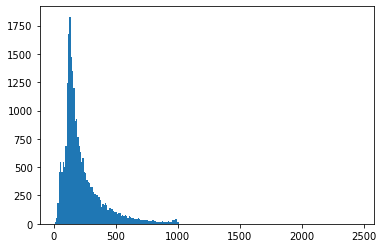

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

In [189]:
train_df = train_df.drop('change_ner',axis=1)
train_df

,is_positive,review,clean,lemm,ent_iob,ent_type,lemma_text
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirls, despite, fistful, tony, wins, incr...","[Dreamgirls, ,, despite, its, fistful, of, Ton...","[B, O, O, O, O, O, B, O, O, B, I, I, I, O, B, ...","[WORK_OF_ART, , , , , , WORK_OF_ART, , , DATE,...","Dreamgirls, ,, despite, its, fistful, of, Tony..."
1,0,This show comes up with interesting locations ...,"show, comes, interesting, locations, fast, tra...","[this, show, come, up, with, interesting, loca...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","this, show, come, up, with, interesting, locat..."
2,1,I simply love this movie. I also love the Ramo...,"simply, love, movie, also, love, ramones, sort...","[I, simply, love, this, movie, ., I, also, lov...","[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ...","[, , , , , , , , , , PERSON, , , , , , , , , ,...","I, simply, love, this, movie, ., I, also, love..."
3,0,Spoilers ahead if you want to call them that.....,"spoilers, ahead, want, call, would, almost, re...","[spoiler, ahead, if, you, want, to, call, they...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","spoiler, ahead, if, you, want, to, call, they,..."
4,1,My all-time favorite movie! I have seen many m...,"time, favorite, movie, seen, many, movies, one...","[my, all, -, time, favorite, movie, !, I, have...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","my, all, -, time, favorite, movie, !, I, have,..."
...,...,...,...,...,...,...,...
24995,1,"I am a big fan of the movie, but not for the u...","big, fan, movie, usual, reasons, think, travol...","[I, be, a, big, fan, of, the, movie, ,, but, n...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , PERSON, ,...","I, be, a, big, fan, of, the, movie, ,, but, no..."
24996,0,I'm not going to bother with a plot synopsis s...,"going, bother, plot, synopsis, since, know, mo...","[I, be, not, go, to, bother, with, a, plot, sy...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","I, be, not, go, to, bother, with, a, plot, syn..."
24997,0,This movie . . . I don't know. Why they would ...,"movie, know, would, take, indellible, characte...","[this, movie, ., ., ., I, do, n't, know, ., wh...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[, , , , , , , , , , , , , , , , , , , PERSON,...","this, movie, ., ., ., I, do, n't, know, ., why..."
24998,1,Saw this film on DVD yesterday and was gob-sma...,"saw, film, dvd, yesterday, gob, smacked, flabb...","[see, this, film, on, DVD, yesterday, and, be,...","[O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, ...","[, , , , , DATE, , , , , , , , , , , , , WORK_...","see, this, film, on, DVD, yesterday, and, be, ..."


Кроме этого, нужно перенумеровать как-то слова.

In [190]:
words_counter = Counter((word for text in train_df.lemm for word in text))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 18060


**Задание** Сконвертируйте данные

In [193]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text:
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.lemm, word2idx, 1000)
X_test = convert(test_df.lemm, word2idx, 1000)

C:\Users\lqw\AppData\Local\Temp/ipykernel_16692/3487095871.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
C:\Users\lqw\AppData\Local\Temp/ipykernel_16692/3487095871.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, che

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [197]:
import tensorflow as tf
tf.__version__

'2.6.0-dev20210502'

In [501]:
import tensorflow as tf
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, \
Dropout,Conv1D,BatchNormalization,Input,Activation, GlobalAveragePooling1D,MaxPool1D

In [201]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          1155840   
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,156,611
Trainable params: 1,156,611
Non-trainable params: 0
_________________________________________________________________


In [204]:
model.fit(X_train, train_df.is_positive, batch_size=1024, epochs=10, 
          validation_data=(X_test, test_df.is_positive))
model.evaluate(X_test, test_df.is_positive)

Epoch 1/10
25/25 [==============================] - 1s 42ms/step - loss: 0.1015 - accuracy: 0.9716 - val_loss: 0.2978 - val_accuracy: 0.8767
Epoch 2/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0809 - accuracy: 0.9798 - val_loss: 0.3041 - val_accuracy: 0.8761
Epoch 3/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0640 - accuracy: 0.9858 - val_loss: 0.3151 - val_accuracy: 0.8735
Epoch 4/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0501 - accuracy: 0.9906 - val_loss: 0.3237 - val_accuracy: 0.8720
Epoch 5/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0391 - accuracy: 0.9938 - val_loss: 0.3327 - val_accuracy: 0.8711
Epoch 6/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0306 - accuracy: 0.9962 - val_loss: 0.3446 - val_accuracy: 0.8696
Epoch 7/10
25/25 [==============================] - 1s 40ms/step - loss: 0.0240 - accuracy: 0.9981 - val_loss: 0.3546 - val_accuracy: 0.8694
Epoch 8/10
25

[0.38540592789649963, 0.8664799928665161]

Эта модель дает результаты хуже чем линенай ренрессия  
Попробуем другую сеть

In [512]:
input_x = Input(shape=(1000))
x= Embedding(input_dim=len(word2idx), output_dim=128, input_shape=(X_train.shape[1],))(input_x)
x = Conv1D(filters=128,kernel_size =6, strides=1,padding='same')(x)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
x= Activation('relu')(x)
# x = Conv1D(filters=128,kernel_size =6, strides=1,padding='same')(x)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
# x= Activation('relu')(x)
x= GlobalMaxPooling1D()(x)
# x = Dense(units=64)(x)
# x = Dropout(0.3)(x)
# x = BatchNormalization()(x)
# x= Activation('relu')(x)
x = Dense(units=64)(x)
x = Dropout(0.3)(x)
# x = BatchNormalization()(x)
x= Activation('relu')(x)
x = Dense(units=32)(x)
x = Dropout(0.3)(x)
# x = BatchNormalization()(x)
x= Activation('relu')(x)
out_x = Dense(units=1, activation='sigmoid')(x)
model = Model(input_x,out_x)
model.summary()

Model: "model_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(None, 1000)]            0         
_________________________________________________________________
embedding_99 (Embedding)     (None, 1000, 128)         2311680   
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 1000, 128)         98432     
_________________________________________________________________
activation_297 (Activation)  (None, 1000, 128)         0         
_________________________________________________________________
global_max_pooling1d_91 (Glo (None, 128)               0         
_________________________________________________________________
dense_304 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_144 (Dropout)        (None, 64)                0  

In [513]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [514]:
model.fit(X_train, train_df.is_positive, batch_size=1024, epochs=5, 
          validation_data=(X_test, test_df.is_positive))
model.evaluate(X_test, test_df.is_positive)

Epoch 1/5
25/25 [==============================] - 9s 335ms/step - loss: 0.6889 - accuracy: 0.5446 - val_loss: 0.6718 - val_accuracy: 0.7139
Epoch 2/5
25/25 [==============================] - 8s 335ms/step - loss: 0.6111 - accuracy: 0.7182 - val_loss: 0.4903 - val_accuracy: 0.7742
Epoch 3/5
25/25 [==============================] - 8s 336ms/step - loss: 0.4053 - accuracy: 0.8232 - val_loss: 0.3192 - val_accuracy: 0.8645
Epoch 4/5
25/25 [==============================] - 8s 340ms/step - loss: 0.2421 - accuracy: 0.9096 - val_loss: 0.2591 - val_accuracy: 0.8932
Epoch 5/5
782/782 [==============================] - 4s 5ms/step - loss: 0.2675 - accuracy: 0.8952


[0.2675492763519287, 0.8951600193977356]

Как видно результаты улучились, но совсем не много